In [28]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

# PyPSA Network

In [29]:
n = pypsa.Network(name='Armourdale')

N_days=365
N_hours=24

index = pd.date_range(start="2018-01-01", 
                      periods=N_days*N_hours, 
                      freq='h')

n.set_snapshots(index)

Step 1: Add buses

In [30]:
bus_name = 'Residential'
n.add(class_name='Bus',
      name=bus_name,
      carrier='AC')

Step 2: Add energy carriers

In [31]:
n.add(class_name="Carrier", name="grid")
n.add(class_name="Carrier", name="solar")
n.add(class_name="Carrier", name="battery")

Step 3: Add load

In [32]:
load = pd.read_csv("../data/timeseries/residential_elec_load_rescaled.csv", parse_dates=True, index_col='timestamp')

In [33]:
load_resampled = load.loc['2018'].resample('h').mean().sum(axis=1)
load_resampled = load_resampled / 1e3  # kW --> MW

In [34]:
n.add(
    class_name="Load",
    name=f"Load {bus_name}",
    bus=bus_name,
    p_set=load_resampled
)

Step 3: Add weather data

In [35]:
weather = pd.read_csv("../data/timeseries/weather_year.csv", parse_dates=True, index_col=0)
weather.head()

,date_time,temp_db,rel_humidity,wind_speed,wind_direction,ghi,dni,dhi
2018-01-01 00:00:00,2005-01-01 01:00:00,8.0,61,5.7,80,0,0,0
2018-01-01 01:00:00,2005-01-01 02:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 02:00:00,2005-01-01 03:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 03:00:00,2005-01-01 04:00:00,7.0,56,6.2,80,0,0,0
2018-01-01 04:00:00,2005-01-01 05:00:00,7.0,56,5.1,90,0,0,0


In [36]:
# normalize GHI
ghi = weather['ghi'] / weather['ghi'].max()

Step 4: Upload cost data

In [37]:
costs = pd.read_csv("../data/technology_costs.csv", index_col='technology')
costs *= 1e3  # convert /kW to /MW
costs

,Fixed O&M,OCC
technology,,
DistributedWind,35912.100000,5.678577e+06
ResPV,28108.825392,2.630889e+06
Residential Battery Storage,78943.789878,3.157752e+06


Step 5: Add generators to network

In [38]:
def annuity(r, n):
    return r / (1 - 1 / (1 + r)**n)

In [39]:
annuity_adj = annuity(0.07, 20)
annuity_adj

0.09439292574325567

In [40]:
for generator in costs.index:
    if generator == 'DistributedWind':
        pass
    else:
        print(generator)
        annualized_cost = costs.at[generator, 'OCC']*annuity_adj + costs.at[generator,'Fixed O&M']
        print(annualized_cost)
        
        if generator=='ResPV':
            n.add(class_name='Generator',
                    name=generator,
                    bus=bus_name,
                    carrier="solar",
                    capital_cost=annualized_cost,  # $/kW
                    p_min_pu=ghi,
                    p_max_pu=ghi,
                    p_nom_extendable=True,
                    )
        elif generator=='Residential Battery Storage':
            n.add(class_name="StorageUnit",
                    name=generator,
                    bus=bus_name,
                    carrier="battery",
                    capital_cost=annualized_cost,  # $/kW
                    p_nom_extendable=True,
                    max_hours=2.5,
                    cyclic_state_of_charge=False,
                    )
        
        

ResPV
276446.11698458303
Residential Battery Storage
377013.20171200635


In [41]:
from unyt import MWh, kWh

In [42]:
(0.1129/kWh).to(1/MWh)

unyt_quantity(112.9, '1/MWh')

In [43]:
n.add(class_name='Generator',
      name='Evergy Import',
      bus=bus_name,
      carrier='grid',
      capital_cost=0,
      marginal_cost=112.9,
      p_nom_max=2,
      p_nom_extendable=True)

Step 6: Run the model

In [44]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 89.55it/s]
INFO:linopy.io: Writing time: 0.56s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43803 primals, 105124 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [45]:
n.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
ResPV,Residential,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,-0.0
Evergy Import,Residential,PQ,,0.0,0.0,True,0.0,2.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,2.0


In [46]:
n.storage_units

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Residential Battery Storage,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.5,1.0,1.0,0.0,0.0,-0.0


In [47]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Dispatch,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,grid,2.0,0.0,4135.96535,0.00000,4135.96535,0.0,0.236071,0.0,0.0,466950.487985,466950.487985,112.9
Load,-,0.0,0.0,0.00000,4135.96535,-4135.96535,0.0,NaN,0.0,0.0,0.000000,-466950.487985,NaN


In [48]:
n.loads_t.p.max()

Load
Load Residential    1.430806
dtype: float64

In [49]:
n.storage_units_t.p_store

StorageUnit,Residential Battery Storage
snapshot,
2018-01-01 00:00:00,-0.0
2018-01-01 01:00:00,-0.0
2018-01-01 02:00:00,-0.0
2018-01-01 03:00:00,-0.0
2018-01-01 04:00:00,-0.0
...,...
2018-12-31 19:00:00,-0.0
2018-12-31 20:00:00,-0.0
2018-12-31 21:00:00,-0.0


In [50]:
TECH_ORDER = ['grid',
              'solar',
              'battery'
              ]

In [51]:
def power_by_carrier(n):
    p_by_carrier = n.generators_t.p.T.groupby(
        n.generators.carrier).sum().T 
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(
            n.storage_units.carrier).sum().T
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
        
    last_cols = [col for col in p_by_carrier.columns if col not in TECH_ORDER]

    p_by_carrier = p_by_carrier[TECH_ORDER+last_cols]

    return p_by_carrier

In [52]:
def plot_dispatch(n, year=2025, month=7):

    time = (year, f'{year}-0{month}')
    p_by_carrier = power_by_carrier(n).div(1e3)

    # y-limits
    y_min = -n.storage_units_t.p_store.max().max() / 1e3
    y_max = n.loads_t.p_set.sum(axis=1).max() / 1e3
    margin = 0.1
    y_low = (1 + margin) * y_min
    y_high = (1 + margin) * y_max

    fig, ax = plt.subplots(figsize=(12, 6))

    color = p_by_carrier.columns.map(n.carriers.color)

    display(p_by_carrier)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
        ylim=(y_low - margin, y_high + margin)
    )

    charge = p_by_carrier.where(
        p_by_carrier < 0).dropna(
        how="all",
        axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
            ylim=(y_low - margin, y_high + margin)
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k")

    ax.legend(loc=(1.05, 0))
    ax.set_ylabel("GW", fontsize=16)
    plt.tight_layout()

    return fig, ax

<Axes: xlabel='snapshot'>

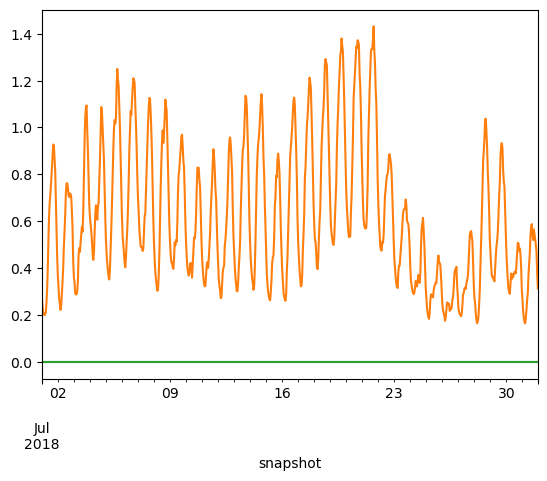

In [53]:
fig, ax = plt.subplots()
time = '2018-07'
n.generators_t.p.loc[time].plot(ax=ax, legend=False)
n.storage_units_t.p_store.loc[time].plot(ax=ax, legend=False)
